In [1]:
import PIL
import torch
import torchvision

from thirdparty.torchvision.detection.utils import collate_fn
import utilities.datasets.cityscapes_dataset
import utilities.models.mask_rcnn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

resized_size = (400, 800)
transforms = torchvision.transforms.Compose([
                 torchvision.transforms.Resize(resized_size),
                 torchvision.transforms.ToTensor(),
             ])
transforms_target = torchvision.transforms.Resize(resized_size, PIL.Image.NEAREST)

dataset = utilities.datasets.cityscapes_dataset.CityscapesDataset('./data/cityscapes/leftImg8bit/train/*', './data/cityscapes/gtFine/train/*', transforms, transforms_target)
dataset_test = utilities.datasets.cityscapes_dataset.CityscapesDataset('./data/cityscapes/leftImg8bit/val/frankfurt', './data/cityscapes/gtFine/val/frankfurt')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1, 
                                               collate_fn=collate_fn)

model = utilities.models.mask_rcnn.MaskRCNN(number_classes = 10 + 1)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [2]:
import os

from thirdparty.torchvision.detection.engine import train_one_epoch #, evaluate

to_load = True
num_epochs = 1

if to_load and os.path.isfile("weights/mask-rcnn-cityscapes.pth"):
    model.load_state_dict(torch.load("weights/mask-rcnn-cityscapes.pth"))

if not os.path.isdir("weights"):
    os.mkdir("weights")
for epoch in range(num_epochs):
    try:
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=200)
        lr_scheduler.step()
        #evaluate(model, data_loader_test, device=device)
        torch.save(model.state_dict(), "weights/mask-rcnn-cityscapes.pth")
    except AttributeError:
        print('Missing AttributeError occurred.')
        continue
    except RuntimeError:
        print('Missing RuntimeError occurred.')
        continue
print("That's it!")

Epoch: [0]  [   0/2975]  eta: 1:00:46  lr: 0.000010  loss: 4.0547 (4.0547)  loss_classifier: 2.1899 (2.1899)  loss_box_reg: 0.5202 (0.5202)  loss_mask: 1.2942 (1.2942)  loss_objectness: 0.0392 (0.0392)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 1.2256  data: 0.2609  max mem: 1719
Loss is nan, skip this data.
Loss is nan, skip this data.
AttributeError occurred.
Loss is nan, skip this data.
Loss is inf, skip this data.
Loss is nan, skip this data.
Epoch: [0]  [ 200/2975]  eta: 0:10:24  lr: 0.000979  loss: 1.5634 (2.2017)  loss_classifier: 0.3229 (0.6239)  loss_box_reg: 0.2488 (0.3749)  loss_mask: 0.3401 (0.5306)  loss_objectness: 0.0558 (0.1886)  loss_rpn_box_reg: 0.5071 (0.4837)  time: 0.2264  data: 0.0066  max mem: 3474
Loss is nan, skip this data.
AttributeError occurred.
AttributeError occurred.
Loss is nan, skip this data.
Loss is nan, skip this data.
Loss is nan, skip this data.
Loss is nan, skip this data.
Epoch: [0]  [ 400/2975]  eta: 0:09:32  lr: 0.001943  loss: 1.2507 (1.8615) 

There are 18 predictions.


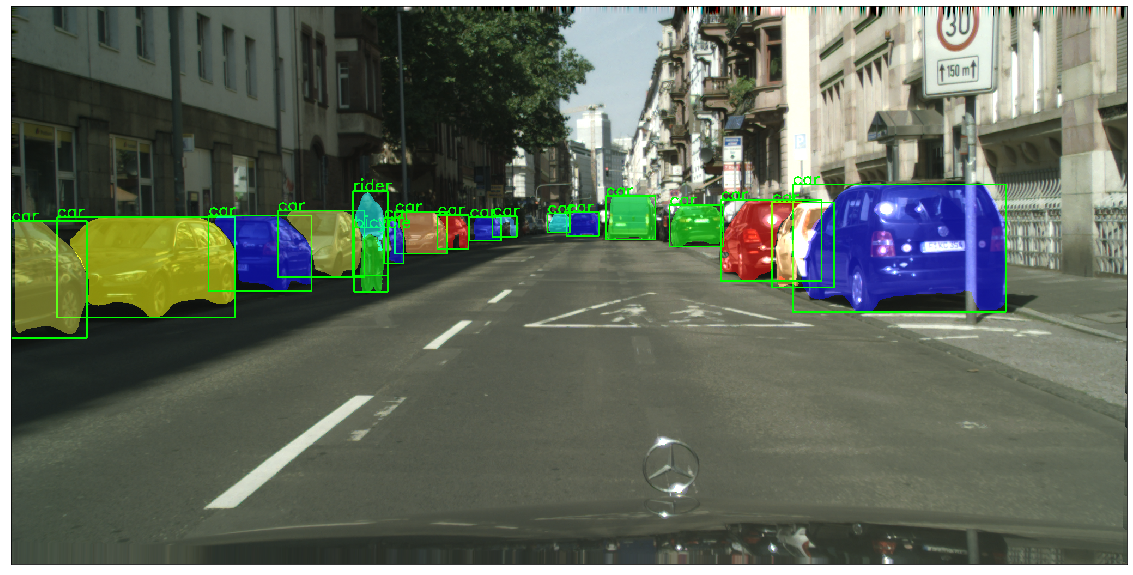

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import utilities.tools.general
import utilities.tools.instance_segmentation

CITYSCAPES_INSTANCE_CATEGORY_NAMES= [
    'background',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'caravan',
    'trailer',
    'train',
    'motorcycle',
    'bicycle'
]

def get_predictions(image, threshold, category_names):
    #with torch.no_grad():
    model.eval()
    predictions = model([image.to(device)])[0]
    scores = list(predictions['scores'].detach().cpu().numpy())
    
    predictions_pass_threshold = [scores.index(x) for x in scores if x > threshold]
    if len(predictions_pass_threshold) == 0:
        return None, None, None
    predictions_pass_threshold_last_index = [scores.index(x) for x in scores if x > threshold][-1]
    
    masks = (predictions['masks'] > 0.5).squeeze().detach().cpu().numpy()
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions['boxes'].detach().cpu().numpy())]
    labels = [category_names[i] for i in list(predictions['labels'].cpu().numpy())]

    if predictions_pass_threshold_last_index > 0:
        masks = masks[:predictions_pass_threshold_last_index + 1]
    else:
        if len(masks.shape) == 2:
            masks = np.asarray([masks])
    boxes = boxes[:predictions_pass_threshold_last_index + 1]
    labels = labels[:predictions_pass_threshold_last_index + 1]
    
    return masks, boxes, labels

image, _ = utilities.tools.general.get_random_data(dataset_test)
masks, boxes, labels = get_predictions(image, 0.8, CITYSCAPES_INSTANCE_CATEGORY_NAMES)
n = 0 if labels == None else len(labels)
if n < 1:
    print("There is no prediction.")
elif n == 1:
    print("There is 1 prediction.")
else:
    print("There are %d predictions." % n)

image = image.mul(255).permute(1, 2, 0).byte().numpy()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

rectangle_thickness = 2
text_size = 1
text_thickness = 2
result = np.copy(image)
for i in range(0, n):
    colored_mask = utilities.tools.instance_segmentation.get_random_colored_mask(masks[i])
    result = cv2.addWeighted(result, 1, colored_mask, 0.5, 0)
    cv2.rectangle(result, boxes[i][0], boxes[i][1], color = (0, 255, 0), thickness = rectangle_thickness)
    cv2.putText(result, str(labels[i]), boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), thickness = text_thickness)
plt.figure(figsize=(20,30))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
import shutil

to_clear_outputs = False

if to_clear_outputs and os.path.isdir('outputs'):
    shutil.rmtree('outputs')

def output(dataset, threshold, directory = 'outputs', rectangle_thickness = 1, text_size = 1.5, text_thickness = 2):
    os.makedirs(directory, exist_ok=True)
    model.eval()
    for i, (image, _) in enumerate(dataset):
        try:
            masks, boxes, labels = get_predictions(image, 0.8, CITYSCAPES_INSTANCE_CATEGORY_NAMES)
            image = image.mul(255).permute(1, 2, 0).byte().numpy()
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            n = 0 if labels == None else len(labels)
            result = np.copy(image)
            for j in range(0, n):
                colored_mask = utilities.tools.instance_segmentation.get_random_colored_mask(masks[j])
                result = cv2.addWeighted(result, 1, colored_mask, 0.5, 0)
                cv2.rectangle(result, boxes[j][0], boxes[j][1], color = (0, 255, 0), thickness = rectangle_thickness)
                cv2.putText(result, str(labels[j]), boxes[j][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), thickness = text_thickness)
            cv2.imwrite(os.path.join(directory, "%05d_result_%03d.png" % (i, n)), result)
        except IOError: # NameError:
            print("NameError at", i)

output(dataset_test, 0.8, 'outputs/cityscapes')
print('Output CityScapes done.')

Output CityScapes done.
